<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory notebook

In [1]:
!pip install netCDF4
!pip install imagecodecs

In [2]:
import os

from tifffile import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from netCDF4 import Dataset as ncDataset
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
# Initialize RNG
rng = np.random.default_rng()

# Check if running with GPU runtime
torch.cuda.is_available()

False

## Pull latest from git repos

In [ ]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/EMIT-ECOSTRESS')
!git pull https://github.com/DannyCollinson/EMIT-ECOSTRESS.git

From https://github.com/DannyCollinson/EMIT-ECOSTRESS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [ ]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/VITALS')
!git pull https://github.com/DannyCollinson/VITALS.git

From https://github.com/DannyCollinson/VITALS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Load and explore ECOSTRESS average LST data LA day/night summer 2018-2021

In [ ]:
im_day = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif')
im_night = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif')

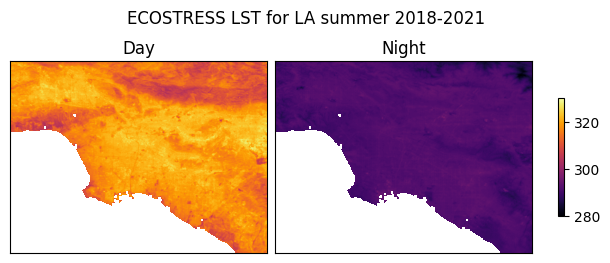

In [ ]:
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(6, 2.75))
fig.suptitle('ECOSTRESS LST for LA summer 2018-2021')
axs[0].title.set_text('Day')
axs[1].title.set_text('Night')
normalizer = Normalize(
    min(np.nanmin(im_day), np.nanmin(im_night)),
    max(np.nanmax(im_day), np.nanmax(im_night)),
)
axs[0].imshow(im_day, norm=normalizer, cmap='inferno')
axs[1].imshow(im_night, norm=normalizer, cmap='inferno')
axs[0].set_xticks([],[])
axs[1].set_xticks([],[])
axs[0].set_yticks([],[])
axs[1].set_yticks([],[])
fig.colorbar(
    ScalarMappable(normalizer, 'inferno'), ax=axs, shrink=0.5, fraction=0.5
)
plt.show(fig)

In [ ]:
day_vals = im_day[~np.isnan(im_day)]
night_vals = im_night[~np.isnan(im_night)]

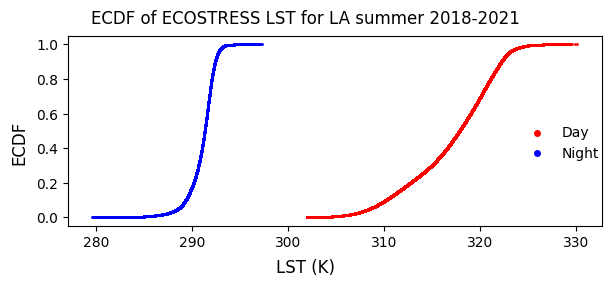

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(6, 2.75))
fig.suptitle('ECDF of ECOSTRESS LST for LA summer 2018-2021')
fig.supylabel('ECDF')
fig.supxlabel('LST (K)')
ax.scatter(
    np.sort(day_vals),
    np.arange(1, len(day_vals) + 1) / len(day_vals),
    s=1,
    c='r',
    label='Day'
)
ax.scatter(
    np.sort(night_vals),
    np.arange(1, len(night_vals) + 1) / len(night_vals),
    s=1,
    c='b',
    label='Night'
)
fig.legend(loc='right', markerscale=4, frameon=False)
plt.show()

## Load and explore EMIT data 2023-07-28

In [7]:
# emit_002 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc')
emit_003 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc')
for key in vars(emit_003).keys():
    continue
    print(key)
    # print(vars(emit_002)[key])
    print(vars(emit_003)[key], end='\n\n')

In [8]:
# emit_002_data = emit_002.variables['reflectance'][:,:,:]
emit_003_data = emit_003.variables['reflectance'][:,:,:]
np.sum(emit_003_data.mask)# , np.sum(emit_002_data.mask)

0

#### Visualize spectra

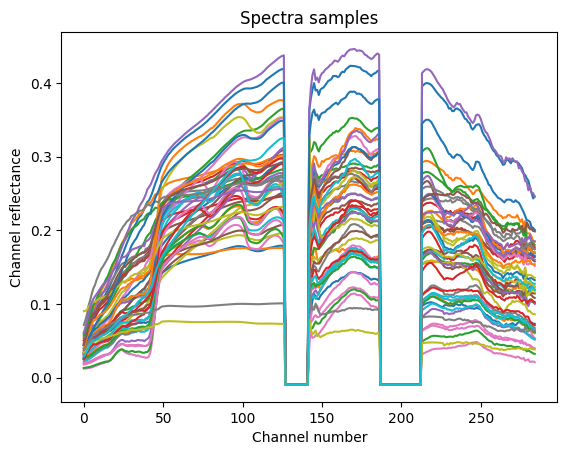

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Spectra samples')
ax.set_xlabel('Channel number')
ax.set_ylabel('Channel reflectance')
num_spectra = 50
for i, j in zip(
    rng.choice(np.arange(emit_003_data.shape[0]), size=num_spectra),
    rng.choice(np.arange(emit_003_data.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(emit_003_data[i,j,:].data)),
        emit_003_data[i,j,:].data,
    )
plt.show(fig)

#### Visualize value distribution

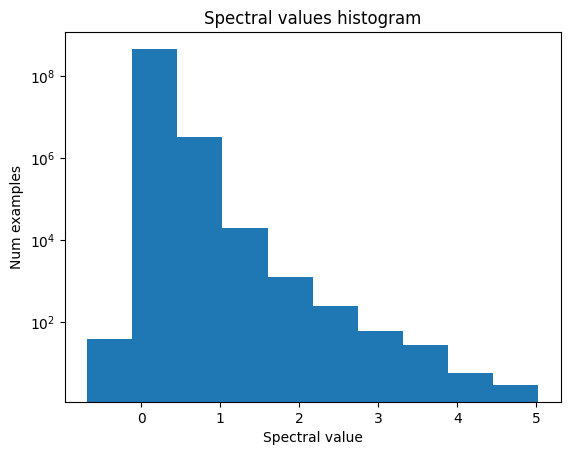

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Spectral values histogram')
ax.set_xlabel('Spectral value')
ax.set_ylabel('Num examples')
ax.hist(emit_003_data[:, :, :].flatten(), log=True)
plt.show(fig)

#### Clean EMIT data and revisualize
We want to clip values to the range [0,1] and remove the channels that are always 0.

In [ ]:
emit_003_data = np.clip(emit_003_data, 0, 1)
emit_003_data = emit_003_data[:, :, np.sum(emit_003_data, axis=(0,1)) != 0]

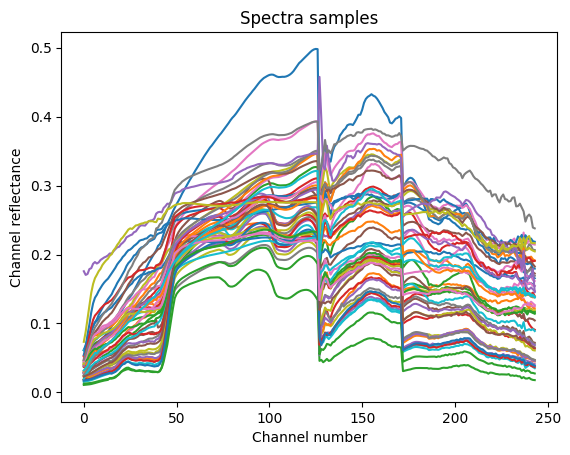

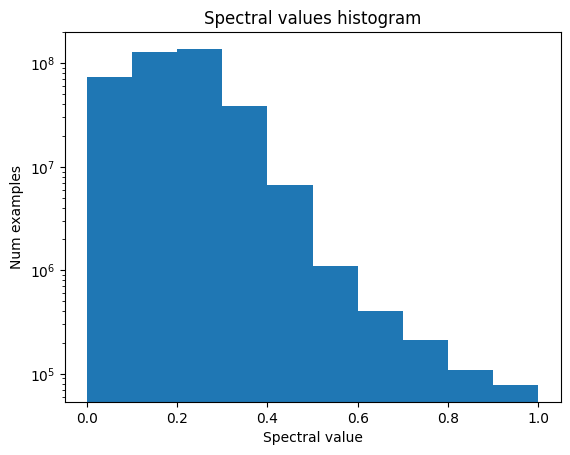

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Spectra samples')
ax.set_xlabel('Channel number')
ax.set_ylabel('Channel reflectance')
num_spectra = 50
for i, j in zip(
    rng.choice(np.arange(emit_003_data.shape[0]), size=num_spectra),
    rng.choice(np.arange(emit_003_data.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(emit_003_data[i,j,:].data)),
        emit_003_data[i,j,:].data,
    )
plt.show(fig)

fig, ax = plt.subplots()
ax.title.set_text('Spectral values histogram')
ax.set_xlabel('Spectral value')
ax.set_ylabel('Num examples')
ax.hist(emit_003_data[:, :, :].flatten(), log=True)
plt.show(fig)

## PCA on spectra

#### Standard PCA

In [ ]:
pca = PCA(n_components=0.9999)
pca_spectra = pca.fit_transform(
    emit_003_data.reshape(
        emit_003_data.shape[0] * emit_003_data.shape[1],
        emit_003_data.shape[2],
    )
)
pca_spectra = pca_spectra.reshape(
    emit_003_data.shape[0],
    emit_003_data.shape[1],
    pca_spectra.shape[1],
)

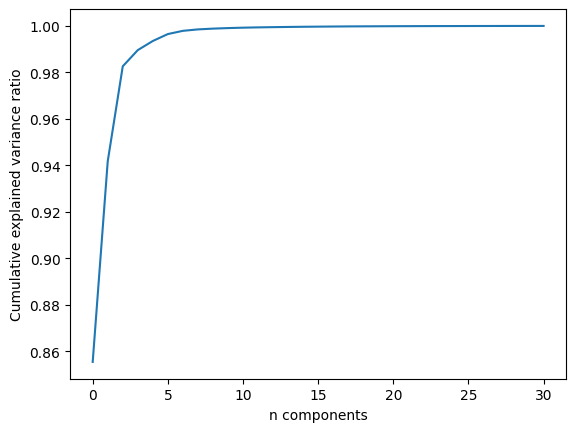

[0.8553722213883312,
 0.9416675100341239,
 0.9825310741670326,
 0.9895021066198121,
 0.9934228653697285,
 0.9964023011054659,
 0.997789208307897,
 0.9984080356643232,
 0.9987390812404222,
 0.9989713220701035]

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('n components')
ax.set_ylabel('Cumulative explained variance ratio')
ax.plot(np.arange(len(pca.explained_variance_ratio_)), [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)])
plt.show(fig)
[np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)][:10]

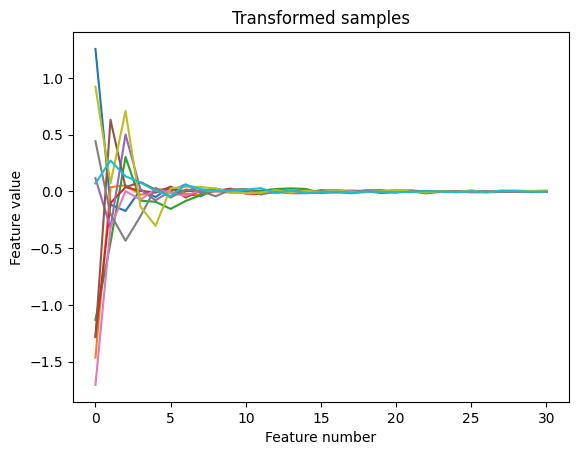

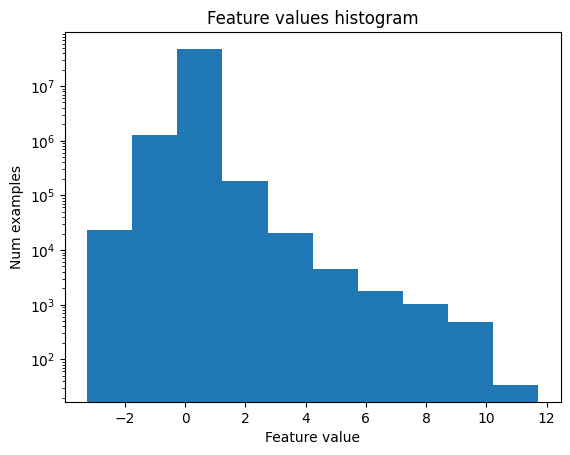

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Transformed samples')
ax.set_xlabel('Feature number')
ax.set_ylabel('Feature value')
num_spectra = 10
for i, j in zip(
    rng.choice(np.arange(pca_spectra.shape[0]), size=num_spectra),
    rng.choice(np.arange(pca_spectra.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(pca_spectra[i,j,:])),
        pca_spectra[i,j,:],

    )
plt.show(fig)

fig, ax = plt.subplots()
ax.title.set_text('Feature values histogram')
ax.set_xlabel('Feature value')
ax.set_ylabel('Num examples')
ax.hist(pca_spectra[:, :, :].flatten(), log=True)
plt.show(fig)

#### Whitened PCA

In [ ]:
white_pca_spectra = pca_spectra * np.sqrt(pca.n_samples_) / pca.singular_values_

In [ ]:
fig, ax = plt.subplots()
ax.title.set_text('Transformed samples')
ax.set_xlabel('Feature number')
ax.set_ylabel('Feature value')
num_spectra = 10
for i, j in zip(
    rng.choice(np.arange(white_pca_spectra.shape[0]), size=num_spectra),
    rng.choice(np.arange(white_pca_spectra.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(white_pca_spectra[i,j,:])),
        white_pca_spectra[i,j,:],

    )
plt.show(fig)

fig, ax = plt.subplots()
ax.title.set_text('Feature values histogram')
ax.set_xlabel('Feature value')
ax.set_ylabel('Num examples')
ax.hist(white_pca_spectra[:, :, :].flatten(), log=True)
plt.show(fig)

#### Kernel PCA

In [ ]:
# num_fitting_spectra = 1000
# kernel_pca_data = np.zeros((num_fitting_spectra, emit_003_data.shape[2]))
# for n, i, j in zip(
#     np.arange(num_fitting_spectra),
#     rng.choice(np.arange(emit_003_data.shape[0]), size=num_fitting_spectra),
#     rng.choice(np.arange(emit_003_data.shape[1]), size=num_fitting_spectra),
# ):
#     kernel_pca_data[n, :] = emit_003_data[i, j, :]

##### RBF kernel

In [ ]:
# rbf_pca = KernelPCA(n_components=1, kernel='rbf', copy_X=False)
# rbf_pca.fit(kernel_pca_data)
# rbf_pca_spectra = rbf_pca.transform(
#     emit_003_data.reshape(
#         emit_003_data.shape[0] * emit_003_data.shape[1],
#         kernel_pca_data.shape[1],
#     )
# )
# rbf_pca_spectra = rbf_pca_spectra.reshape(
#     emit_003_data.shape[0],
#     emit_003_data.shape[1],
#     rbf_pca_spectra.shape[1])

In [45]:
# fig, ax = plt.subplots()
# ax.set_xlabel('n components')
# ax.set_ylabel('Cumulative explained variance ratio')
# ax.plot(np.arange(len(rbf_pca.explained_variance_ratio_)), [np.sum(rbf_pca.explained_variance_ratio_[:i]) for i in range(1,len(rbf_pca.explained_variance_ratio_) + 1)])
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Transformed samples')
# ax.set_xlabel('Feature number')
# ax.set_ylabel('Feature value')
# num_spectra = 10
# for i, j in zip(
#     rng.choice(np.arange(rbf_pca_spectra.shape[0]), size=num_spectra),
#     rng.choice(np.arange(rbf_pca_spectra.shape[1]), size=num_spectra),
# ):
#     ax.semilogy(
#         np.arange(len(rbf_pca_spectra[i,j,:])),
#         rbf_pca_spectra[i,j,:],

#     )
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Feature values histogram')
# ax.set_xlabel('Feature value')
# ax.set_ylabel('Num examples')
# ax.hist(rbf_pca_spectra[:, :, :].flatten(), log=True)
# plt.show(fig)

# [np.sum(rbf_pca.explained_variance_ratio_[:i]) for i in range(1,len(rbf_pca.explained_variance_ratio_) + 1)][:10]

##### Cosine kernel

In [46]:
# cosine_pca = KernelPCA(n_components=1, kernel='cosine', copy_X=False)
# cosine_pca.fit(kernel_pca_data)
# cosine_pca_spectra = cosine_pca.transform(
#     emit_003_data.reshape(
#         emit_003_data.shape[0] * emit_003_data.shape[1],
#         kernel_pca_data.shape[1],
#     )
# )
# cosine_pca_spectra = cosine_pca_spectra.reshape(
#     emit_003_data.shape[0],
#     emit_003_data.shape[1],
#     cosine_pca_spectra.shape[1])

In [47]:
# fig, ax = plt.subplots()
# ax.set_xlabel('n components')
# ax.set_ylabel('Cumulative explained variance ratio')
# ax.plot(np.arange(len(cosine_pca.explained_variance_ratio_)), [np.sum(cosine_pca.explained_variance_ratio_[:i]) for i in range(1,len(cosine_pca.explained_variance_ratio_) + 1)])
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Transformed samples')
# ax.set_xlabel('Feature number')
# ax.set_ylabel('Feature value')
# num_spectra = 1
# for i, j in zip(
#     rng.choice(np.arange(cosine_pca_spectra.shape[0]), size=num_spectra),
#     rng.choice(np.arange(cosine_pca_spectra.shape[1]), size=num_spectra),
# ):
#     ax.semilogy(
#         np.arange(len(cosine_pca_spectra[i,j,:])),
#         cosine_pca_spectra[i,j,:],

#     )
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Feature values histogram')
# ax.set_xlabel('Feature value')
# ax.set_ylabel('Num examples')
# ax.hist(cosine_pca_spectra[:, :, :].flatten(), log=True)
# plt.show(fig)

# [np.sum(cosine_pca.explained_variance_ratio_[:i]) for i in range(1,len(cosine_pca.explained_variance_ratio_) + 1)][:10]

##### Polynomial kernel

In [48]:
# poly_pca = KernelPCA(n_components=1, kernel='poly', copy_X=False)
# poly_pca.fit(kernel_pca_data)
# poly_pca_spectra = poly_pca.transform(
#     emit_003_data.reshape(
#         emit_003_data.shape[0] * emit_003_data.shape[1],
#         kernel_pca_data.shape[1],
#     )
# )
# poly_pca_spectra = poly_pca_spectra.reshape(
#     emit_003_data.shape[0],
#     emit_003_data.shape[1],
#     poly_pca_spectra.shape[1])

In [49]:
# fig, ax = plt.subplots()
# ax.set_xlabel('n components')
# ax.set_ylabel('Cumulative explained variance ratio')
# ax.plot(np.arange(len(poly_pca.explained_variance_ratio_)), [np.sum(poly_pca.explained_variance_ratio_[:i]) for i in range(1,len(poly_pca.explained_variance_ratio_) + 1)])
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Transformed samples')
# ax.set_xlabel('Feature number')
# ax.set_ylabel('Feature value')
# num_spectra = 1
# for i, j in zip(
#     rng.choice(np.arange(poly_pca_spectra.shape[0]), size=num_spectra),
#     rng.choice(np.arange(poly_pca_spectra.shape[1]), size=num_spectra),
# ):
#     ax.semilogy(
#         np.arange(len(poly_pca_spectra[i,j,:])),
#         poly_pca_spectra[i,j,:],

#     )
# plt.show(fig)

# fig, ax = plt.subplots()
# ax.title.set_text('Feature values histogram')
# ax.set_xlabel('Feature value')
# ax.set_ylabel('Num examples')
# ax.hist(poly_pca_spectra[:, :, :].flatten(), log=True)
# plt.show(fig)

# [np.sum(poly_pca.explained_variance_ratio_[:i]) for i in range(1,len(poly_pca.explained_variance_ratio_) + 1)][:10]

## Data exploration

#### EMIT data: raw vs PCA vs PCA+whitening

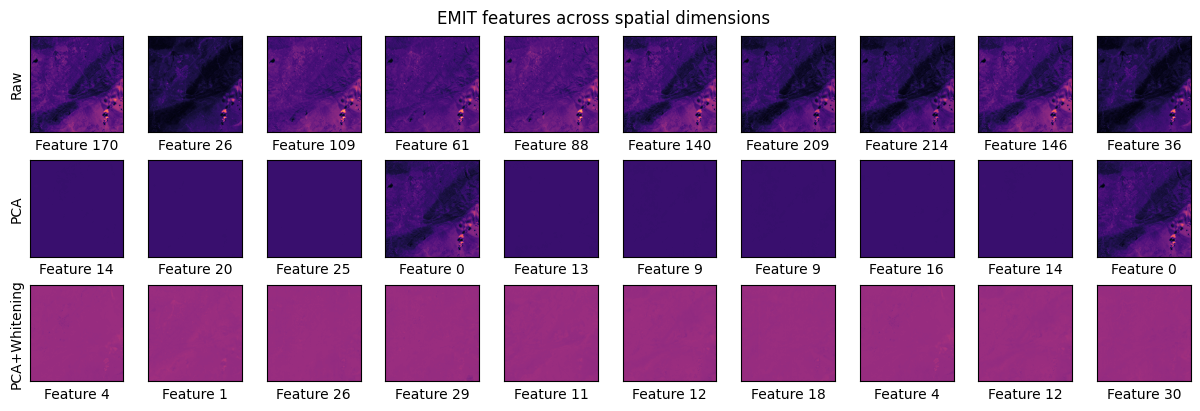

In [50]:
num_samples = 10
fig, axs = plt.subplots(3, num_samples, figsize=(12,4), layout='constrained')
fig.suptitle('EMIT features across spatial dimensions')
for ind, source in enumerate([emit_003_data, pca_spectra, white_pca_spectra]):
    n = rng.choice(source.shape[2], size=num_samples)
    normalizer = Normalize(
        min([np.nanmin(source[:, :, n[i]]) for i in range(num_samples)]),
        max([np.nanmax(source[:, :, n[i]]) for i in range(num_samples)]),
    )
    for i in range(num_samples):
        if i == 0:
            axs[ind, i].set_ylabel(['Raw', 'PCA', 'PCA+Whitening'][ind])
        axs[ind, i].set_xlabel(f'Feature {n[i]}')
        axs[ind, i].imshow(source[:, :, n[i]], norm=normalizer, cmap='magma')
        axs[ind, i].set_xticks([],[])
        axs[ind, i].set_yticks([],[])
plt.show(fig)

#### Landsat and other data

In [4]:
albedo = tifffile.imread(
    '/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/Landsat_Albedo_LA.tif'
)
ndvi = tifffile.imread(
    '/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/Landsat_NDVI_LA.tif'
)
dem = tifffile.imread(
    '/content/drive/Shareddrives/emit-ecostress/Data/NASADEM_NC.001_NASADEM_HGT_doy2000042_aid0001.tif'
)
# canopy = tifffile.imread(
#     '/content/drive/Shareddrives/emit-ecostress/Data/Los_Angeles_and_Long_Beach_and_Anaheim/urbancanopy2018/Los_Angeles_and_Long_Beach_and_Anaheim_canopy2018.tif.ovr'
# )
# socab = tifffile.imread(
#     '/content/drive/Shareddrives/emit-ecostress/Data/SoCAB_Willow_Coleman_map.tif'
# )

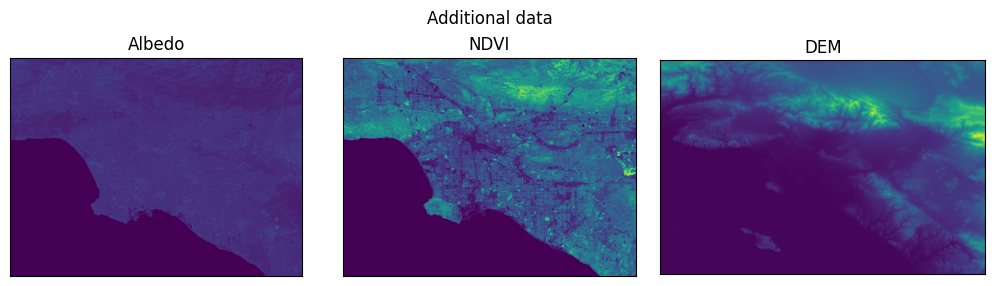

In [5]:
to_plot = [['Albedo', albedo], ['NDVI', ndvi], ['DEM', dem]]
fig, axs = plt.subplots(1, len(to_plot), layout='constrained', figsize=(10, 2.75))
fig.suptitle('Additional data')
for i in range(len(to_plot)):
    axs[i].title.set_text(to_plot[i][0])
    axs[i].imshow(to_plot[i][1])
    axs[i].set_xticks([],[])
    axs[i].set_yticks([],[])
plt.show(fig)

## Data Matching

In [9]:
emit_003.groups['location'], emit_003.geotransform, vars(emit_003)

(<class 'netCDF4._netCDF4.Group'>
 group /location:
     dimensions(sizes): 
     variables(dimensions): float64 lon(downtrack, crosstrack), float64 lat(downtrack, crosstrack), float64 elev(downtrack, crosstrack), int32 glt_x(ortho_y, ortho_x), int32 glt_y(ortho_y, ortho_x)
     groups: ,
 array([-1.18200459e+02,  5.42232520e-04, -0.00000000e+00,  3.47009308e+01,
        -0.00000000e+00, -5.42232520e-04]),
 {'ncei_template_version': 'NCEI_NetCDF_Swath_Template_v2.0',
  'summary': "The Earth Surface Mineral Dust Source Investigation (EMIT) is an Earth Ventures-Instrument (EVI-4) Mission that maps the surface mineralogy of arid dust source regions via imaging spectroscopy in the visible and short-wave infrared (VSWIR). Installed on the International Space Station (ISS), the EMIT instrument is a Dyson imaging spectrometer that uses contiguous spectroscopic measurements from 410 to 2450 nm to resolve absoprtion features of iron oxides, clays, sulfates, carbonates, and other dust-forming mi

In [12]:
# im_slt = tifffile.imread(
#     '/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/ECOv002_L2T_LSTE_28691_004_11SLT_20230728T214058_0710_01_LST.tif'
# )
# im_slu = tifffile.imread(
#     '/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/ECOv002_L2T_LSTE_28691_004_11SLU_20230728T214058_0710_01_LST.tif'
# )
im_smt = tifffile.imread(
    '/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/ECOv002_L2T_LSTE_28691_004_11SMT_20230728T214058_0710_01_LST.tif'
)

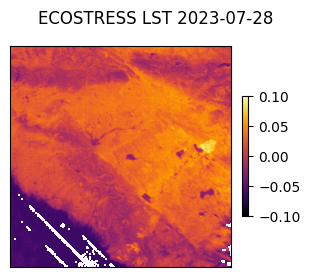

In [22]:
fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(3, 2.75))
fig.suptitle('ECOSTRESS LST 2023-07-28')
ax.imshow(im_smt, cmap='inferno')
ax.set_xticks([],[])
ax.set_yticks([],[])
fig.colorbar(
    ScalarMappable(Normalize(im_smt.min(), im_smt.max()), 'inferno'),
    ax=ax,
    shrink=0.5,
    fraction=0.5,
)
plt.show(fig)